### An outline of what I hope to accomplish

1. Load in digits data
2. Use Fiedler embedding to reduce dimension to 6
3. Compute local density.
4. Apply mapper code using the local density of the Fiedler embedding

In [48]:
import sys
import numpy
import itertools
from matplotlib import pyplot

In [49]:
%matplotlib inline

In [2]:
from sklearn.datasets import load_digits

## 1. Load digits

Step 1 is easy. The only work lies in turning an 8x8 grid into a 64 long vector. We use the `reshape` command.

In [30]:
dataset = load_digits()
n_samples = len(dataset.images)

In [31]:
digits = dataset.images.reshape((n_samples,-1))

## 2. Fiedler embedding

Now we run into trouble because I don't know what a Fiedler embedding is.

A perhaps related phrase I know is "Fiedler vector". This is a vector associated to a graph. Given a graph, compute the Laplacian matrix. Then compute and order the eigenvalues. The eigenvector corresponding to the second-smallest eigenvalue is the Fiedler vector. People find the concept useful and all the words meaningful.

I found this at Gitlab:

https://github.com/aneesha/Fiedler-Embeddings.git

They credit the notion of Fiedler embedding to Sandia Labs. From http://www.siam.org/meetings/sdm06/workproceed/Text%20Mining/hendrickson22.pdf

Given a graph:
1. Generate Laplacian matrix
2. Compute eigenvectors $u_2,\dots,u_{k+1}$, where eigenvectors are ordered by the corresponding eigenvalues, with $u_1$ corresponding to the smallest. Thus $u_2$ is the Fiedler vector.
3. Let $Q = [u_2,\dots, u_{k+1}]$.
4. Position vertex i at $\Delta^{1/2}Q^Te_i,$ where $e_i$ is the one-hot vector that is all zeroes except for a 1 in the $i$th position.

∆ is described as a "diagonal, non-negative matrix of coordinate scalings". I'll let you puzzle out what exactly that matrix should look like.

The fiedlerembedding code isn't good by most standards. Not a package one can install. Python2. And importing it just spits stuff to the screen. So I stuck it in a folder in my path, ran 2to3 on it, and added a `__name__=='__main'`

In [5]:
import fiedlerembedding

In [8]:
# This runs the example given
fiedlerembedding.main()

[[  1.07309178e-08   1.07309178e-08   1.07309178e-08   1.07309178e-08
    1.07309178e-08   1.07309178e-08   1.07309178e-08   1.07309178e-08
    1.07309178e-08   1.07309178e-08   1.07309178e-08   1.07309178e-08
    1.07309178e-08   1.07309178e-08   1.07309178e-08   1.07309178e-08
    1.07309178e-08   1.07309178e-08   1.07309178e-08   1.07309178e-08
    1.07309178e-08]
 [ -1.08446518e-01  -1.17011359e-01  -1.05143939e-01  -1.05751595e-01
   -1.41384439e-01  -1.09768349e-01  -1.05143939e-01  -1.08863118e-01
    1.83082235e-01  -2.20175131e-02   2.47207340e-01   1.96657372e-01
   -9.51410743e-02  -1.22183101e-01  -1.14775133e-01  -1.13342837e-01
   -1.80893650e-01   2.95001263e-01   2.47337607e-01   2.30282111e-01
    1.50298635e-01]]
[  1.07309178e-08  -1.05143939e-01]
[0 1]
computer
EPS


###### Now, the example of Fiedler embedding in the code starts with the document-term matrix, where the rows represent documents and the columns terms.

The description above is considered more general, and begins with a graph, which is representable by an adjacency matrix, where both rows and columns represent vertices.

We have these images.

How do they connect?

Well, matrices. Each image when pixellated is a 256-entry vector. We can make a matrix, one row per image. That should work as an input to the fiedlerembedding code.

Which does the work to build a square matrix out of the whole thing.

In [36]:
# Choose the dimension of your embedding
k = 6

In [35]:
L = fiedlerembedding.createLaplacian(digits)

In [37]:
S = fiedlerembedding.fiedlerEmbeddedSpace(L,k)

/Users/chrisn/mad-science/fiedlerembedding.py:59: RuntimeWarning: invalid value encountered in sqrt
  eval_k = diag(eval_k,0)**0.5


I got a runtime warning about null values and square roots. I chose to ignore it.

In [40]:
S.shape

(6, 1861)

I have a 6x1861 array. I was expecting 1797x6. But may have misunderstood something.

## 3. Local density

To each of our 1797 images, we associate a local density. The number of images in a ball of fixed radius around our given image.

What radius to pick?

And Bill's blog suggested computing local density not on the given 64-dimensional space, but rather on a 6-dimensional space. The above was supposed to deal with that, but I'm not overly satisfied.

Pressing forward anyway, we define a radius.

In [81]:
mymatrix = digits # Perhaps change to the Fiedler embedding if that works.r4fr

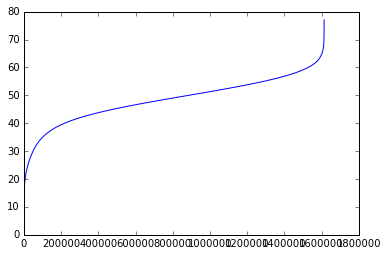

In [79]:
distances = numpy.zeros((n_samples,n_samples))
for i,j in itertools.combinations(range(n_samples),2):
    distances[i,j] = numpy.linalg.norm(mymatrix[i]-mymatrix[j])

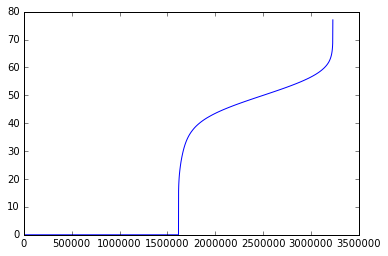

In [85]:
flat = distances.flatten()
flat.sort()
pyplot.plot(flat);

With any luck, the picture above suggests a good radius to call close.

In [86]:
r = 20

In [90]:
# Then this numpy array represents your local densities.
(distances < 20).sum(axis=1)

array([  44,    6,    4, ..., 1795, 1796, 1797])

## 4. Next comes the mapper code

But first we should really get the above working.